# Facial Recognition Model Performance Comparison

This notebook provides a comprehensive framework for comparing facial recognition models using the DeepFace library. It's designed to be extensible for multiple datasets and includes future fine-tuning capabilities.

## Features:
- **Multi-Model Comparison**: Compare various DeepFace models (VGG-Face, Facenet, OpenFace, etc.)
- **Extensible Dataset Support**: Currently supports LFW dataset with framework for adding others
- **Performance Metrics**: Accuracy, Precision, Recall, F1-Score evaluation
- **Visualization**: Comprehensive charts and performance comparisons
- **Fine-tuning Ready**: Framework setup for future model customization

## Dataset Structure:
- LFW (Labeled Faces in the Wild) dataset in `dataset/lfw/` folder
- Extensible structure for additional datasets

## 1. Import Required Libraries

In [9]:
# Core libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Deep learning and computer vision
import cv2
from PIL import Image

# DeepFace library for facial recognition
try:
    from deepface import DeepFace
    print("✅ DeepFace imported successfully")
except ImportError:
    print("❌ DeepFace not found. Install using: pip install deepface")

# Additional utilities
import json
import time
from datetime import datetime
import pickle
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📚 All libraries imported successfully!")
print(f"📅 Notebook initialized on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ DeepFace imported successfully
📚 All libraries imported successfully!
📅 Notebook initialized on: 2025-07-23 13:24:26


## 2. Setup Configuration and Parameters

Define configuration parameters for datasets, models, evaluation metrics, and file paths. This section creates an extensible structure for adding new datasets and models.

In [10]:
@dataclass
class DatasetConfig:
    """Configuration class for dataset parameters"""
    name: str
    path: str
    image_folder: str
    pairs_file: Optional[str] = None
    people_file: Optional[str] = None
    train_pairs: Optional[str] = None
    test_pairs: Optional[str] = None
    dataset_type: str = 'structured'  # 'structured' (with CSV files) or 'folder_based' (folders only)

@dataclass
class ModelConfig:
    """Configuration class for model parameters"""
    name: str
    backend: str
    distance_metric: str = 'cosine'
    enforce_detection: bool = True

# Dataset configurations (extensible structure)
DATASET_CONFIGS = {
    'lfw': DatasetConfig(
        name='LFW',
        path='dataset/lfw',
        image_folder='lfw-deepfunneled/lfw-deepfunneled',
        pairs_file='pairs.csv',
        people_file='people.csv',
        train_pairs='matchpairsDevTrain.csv',
        test_pairs='matchpairsDevTest.csv',
        dataset_type='structured'
    ),
    'asian_celeb': DatasetConfig(
        name='Asian Celebrity',
        path='dataset/asian_celeb_112x112_folders',
        image_folder='.',  # Images are directly in the dataset folder
        dataset_type='folder_based'
    ),
    # Future datasets can be added here
    # 'celeba': DatasetConfig(...),
    # 'vggface2': DatasetConfig(...),
}

# Available DeepFace models for comparison
DEEPFACE_MODELS = [
    ModelConfig('VGG-Face', 'VGG-Face'),
    ModelConfig('Facenet', 'Facenet'),
    ModelConfig('Facenet512', 'Facenet512'),
    ModelConfig('OpenFace', 'OpenFace'),
    ModelConfig('DeepFace', 'DeepFace'),
    ModelConfig('DeepID', 'DeepID'),
    ModelConfig('ArcFace', 'ArcFace'),
    ModelConfig('Dlib', 'Dlib'),
    ModelConfig('SFace', 'SFace'),
    ModelConfig('GhostFaceNet', 'GhostFaceNet'),
    ModelConfig('Buffalo_L', 'Buffalo_L'),
]

# Evaluation metrics
METRICS = ['accuracy', 'precision', 'recall', 'f1_score']

# Distance metrics for face verification
DISTANCE_METRICS = ['cosine', 'euclidean', 'euclidean_l2']

# Results storage paths
RESULTS_DIR = Path('results')
MODELS_DIR = Path('models')
PLOTS_DIR = Path('plots')

# Create directories if they don't exist
for dir_path in [RESULTS_DIR, MODELS_DIR, PLOTS_DIR]:
    dir_path.mkdir(exist_ok=True)

# Global configuration
CONFIG = {
    'max_samples': None,  # For testing; set to None for full dataset
    'test_size': 0.2,
    'random_state': 42,
    'image_size': (224, 224),
    'batch_size': 32,
    'verbose': True,
    'max_verification_pair':500,
}

print("⚙️ Configuration setup complete!")
print(f"📁 Available datasets: {list(DATASET_CONFIGS.keys())}")
print(f"🤖 Available models: {[model.name for model in DEEPFACE_MODELS]}")
print(f"📊 Evaluation metrics: {METRICS}")
print(f"📏 Distance metrics: {DISTANCE_METRICS}")

⚙️ Configuration setup complete!
📁 Available datasets: ['lfw', 'asian_celeb']
🤖 Available models: ['VGG-Face', 'Facenet', 'Facenet512', 'OpenFace', 'DeepFace', 'DeepID', 'ArcFace', 'Dlib', 'SFace', 'GhostFaceNet', 'Buffalo_L']
📊 Evaluation metrics: ['accuracy', 'precision', 'recall', 'f1_score']
📏 Distance metrics: ['cosine', 'euclidean', 'euclidean_l2']


## 3. Dataset Loading and Preprocessing

Load the LFW dataset and create extensible functions to load other facial recognition datasets. This section implements a preprocessing pipeline for image normalization and validation.

### 📋 Dataset Selection Instructions

This notebook supports multiple dataset types:

1. **LFW Dataset** (`'lfw'`): Structured dataset with predefined CSV files
   - Path: `dataset/lfw/`
   - Contains: `pairs.csv`, `people.csv`, training/test splits
   - Image folder: `lfw-deepfunneled/lfw-deepfunneled/`

2. **Asian Celebrity Dataset** (`'asian_celeb'`): Folder-based dataset
   - Path: `dataset/asian_celeb_112x112_folders/`
   - Contains: Only folders named by person identity
   - Image folder: `.` (root of dataset)
   - Pairs are generated dynamically from folder structure

**To switch datasets**: Change the `SELECTED_DATASET` variable in the next cell and re-run from that cell onwards.

In [11]:
class DatasetLoader:
    """Extensible dataset loader for facial recognition datasets"""
    
    def __init__(self, dataset_config: DatasetConfig):
        self.config = dataset_config
        self.base_path = Path(dataset_config.path)
        self.image_path = self.base_path / dataset_config.image_folder
        
    def load_pairs_data(self) -> pd.DataFrame:
        """Load pairs data for face verification"""
        if self.config.dataset_type == 'folder_based':
            print(f"📂 {self.config.name} is folder-based. Pairs will be generated dynamically.")
            return pd.DataFrame()
        
        try:
            pairs_file = self.base_path / self.config.pairs_file
            if pairs_file.exists():
                pairs_df = pd.read_csv(pairs_file)
                print(f"✅ Loaded {len(pairs_df)} pairs from {self.config.name}")
                return pairs_df
            else:
                print(f"❌ Pairs file not found: {pairs_file}")
                return pd.DataFrame()
        except Exception as e:
            print(f"❌ Error loading pairs data: {e}")
            return pd.DataFrame()
    
    def load_people_data(self) -> pd.DataFrame:
        """Load people/identity data"""
        if self.config.dataset_type == 'folder_based':
            print(f"📂 {self.config.name} is folder-based. People data will be generated from folders.")
            return self._generate_people_data_from_folders()
        
        try:
            people_file = self.base_path / self.config.people_file
            if people_file.exists():
                people_df = pd.read_csv(people_file)
                print(f"✅ Loaded {len(people_df)} people from {self.config.name}")
                return people_df
            else:
                print(f"❌ People file not found: {people_file}")
                return pd.DataFrame()
        except Exception as e:
            print(f"❌ Error loading people data: {e}")
            return pd.DataFrame()
    
    def _generate_people_data_from_folders(self) -> pd.DataFrame:
        """Generate people data from folder structure"""
        try:
            if not self.image_path.exists():
                print(f"❌ Image folder not found: {self.image_path}")
                return pd.DataFrame()
            
            people_data = []
            person_folders = [f for f in self.image_path.iterdir() if f.is_dir()]
            
            for person_folder in person_folders:
                # Count images in each person's folder
                image_count = 0
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                    image_count += len(list(person_folder.glob(ext)))
                
                if image_count > 0:
                    people_data.append({
                        'name': person_folder.name,
                        'folder': person_folder.name,
                        'image_count': image_count
                    })
            
            people_df = pd.DataFrame(people_data)
            print(f"✅ Generated people data from {len(people_df)} folders")
            return people_df
            
        except Exception as e:
            print(f"❌ Error generating people data from folders: {e}")
            return pd.DataFrame()
    
    def get_image_paths(self, max_samples: Optional[int] = None) -> List[str]:
        """Get all available image paths"""
        image_paths = []
        
        if not self.image_path.exists():
            print(f"❌ Image folder not found: {self.image_path}")
            return image_paths
        
        # Recursively find all image files
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            image_paths.extend(list(self.image_path.rglob(ext)))
        
        # Convert to strings and limit samples if specified
        image_paths = [str(path) for path in image_paths]
        
        if max_samples and len(image_paths) > max_samples:
            # For folder-based datasets, try to maintain diversity by sampling from different people
            if self.config.dataset_type == 'folder_based':
                image_paths = self._sample_diverse_images(image_paths, max_samples)
            else:
                image_paths = image_paths[:max_samples]
        
        print(f"✅ Found {len(image_paths)} images in {self.config.name}")
        return image_paths
    
    def _sample_diverse_images(self, image_paths: List[str], max_samples: int) -> List[str]:
        """Sample images to maintain diversity across different people"""
        # Group images by person (folder name)
        person_images = {}
        for path in image_paths:
            person_name = Path(path).parent.name
            if person_name not in person_images:
                person_images[person_name] = []
            person_images[person_name].append(path)
        
        # Calculate how many images per person to maintain diversity
        num_people = len(person_images)
        images_per_person = max(1, max_samples // num_people)
        
        sampled_images = []
        for person_name, person_paths in person_images.items():
            # Sample up to images_per_person from each person
            sample_count = min(images_per_person, len(person_paths))
            sampled_images.extend(np.random.choice(person_paths, sample_count, replace=False))
            
            if len(sampled_images) >= max_samples:
                break
        
        return sampled_images[:max_samples]
    
    def get_people_folders(self) -> Dict[str, List[str]]:
        """Get mapping of person names to their image paths"""
        people_folders = {}
        
        if not self.image_path.exists():
            print(f"❌ Image folder not found: {self.image_path}")
            return people_folders
        
        # Get all person folders
        person_folders = [f for f in self.image_path.iterdir() if f.is_dir()]
        
        for person_folder in person_folders:
            person_name = person_folder.name
            image_paths = []
            
            # Find all images in this person's folder
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                image_paths.extend([str(p) for p in person_folder.glob(ext)])
            
            if image_paths:
                people_folders[person_name] = image_paths
        
        print(f"✅ Found {len(people_folders)} people with images")
        return people_folders
    
    def validate_image(self, image_path: str) -> bool:
        """Validate if image can be loaded and processed"""
        try:
            img = cv2.imread(image_path)
            return img is not None and img.shape[0] > 0 and img.shape[1] > 0
        except:
            return False
    
    def preprocess_image(self, image_path: str, target_size: Tuple[int, int] = (224, 224)) -> Optional[np.ndarray]:
        """Preprocess image for model input"""
        try:
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None
            
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize image
            img = cv2.resize(img, target_size)
            
            # Normalize pixel values
            img = img.astype(np.float32) / 255.0
            
            return img
        except Exception as e:
            if CONFIG['verbose']:
                print(f"❌ Error preprocessing {image_path}: {e}")
            return None

def create_verification_pairs(dataset_loader: DatasetLoader, num_pairs: int = 1000) -> List[Tuple[str, str, int]]:
    """Create pairs for face verification (positive and negative pairs)"""
    
    if dataset_loader.config.dataset_type == 'folder_based':
        return create_verification_pairs_from_folders(dataset_loader, num_pairs)
    else:
        return create_verification_pairs_from_images(dataset_loader, num_pairs)

def create_verification_pairs_from_folders(dataset_loader: DatasetLoader, num_pairs: int = 1000) -> List[Tuple[str, str, int]]:
    """Create verification pairs from folder-based dataset structure"""
    people_folders = dataset_loader.get_people_folders()
    
    if len(people_folders) < 2:
        print("❌ Not enough people to create pairs")
        return []
    
    pairs = []
    people_names = list(people_folders.keys())
    
    # Create positive pairs (same person)
    positive_pairs = 0
    target_positive = num_pairs // 2
    
    for person_name in people_names:
        person_images = people_folders[person_name]
        
        if len(person_images) < 2:
            continue  # Need at least 2 images to create a positive pair
        
        # Create multiple positive pairs for this person
        max_pairs_per_person = min(5, target_positive - positive_pairs)
        
        for _ in range(max_pairs_per_person):
            if positive_pairs >= target_positive:
                break
            
            # Randomly select 2 different images of the same person
            img1, img2 = np.random.choice(person_images, 2, replace=False)
            pairs.append((img1, img2, 1))  # 1 = positive pair
            positive_pairs += 1
    
    # Create negative pairs (different persons)
    negative_pairs = 0
    target_negative = num_pairs // 2
    
    while negative_pairs < target_negative:
        # Randomly select two different people
        person1, person2 = np.random.choice(people_names, 2, replace=False)
        
        # Select one random image from each person
        img1 = np.random.choice(people_folders[person1])
        img2 = np.random.choice(people_folders[person2])
        
        pairs.append((img1, img2, 0))  # 0 = negative pair
        negative_pairs += 1
    
    print(f"✅ Created {len(pairs)} verification pairs ({positive_pairs} positive, {negative_pairs} negative)")
    return pairs

def create_verification_pairs_from_images(dataset_loader: DatasetLoader, num_pairs: int = 1000) -> List[Tuple[str, str, int]]:
    """Create verification pairs from image list (original method for structured datasets)"""
    image_paths = dataset_loader.get_image_paths()
    
    if len(image_paths) < 2:
        print("❌ Not enough images to create pairs")
        return []
    
    pairs = []
    
    # Create positive pairs (same person)
    positive_pairs = 0
    for i, path1 in enumerate(image_paths):
        if positive_pairs >= num_pairs // 2:
            break
        
        # Extract person name from path (assuming folder structure: person_name/image.jpg)
        person1 = Path(path1).parent.name
        
        for j, path2 in enumerate(image_paths[i+1:], i+1):
            person2 = Path(path2).parent.name
            
            if person1 == person2:  # Same person
                pairs.append((path1, path2, 1))  # 1 = positive pair
                positive_pairs += 1
                break
    
    # Create negative pairs (different persons)
    negative_pairs = 0
    while negative_pairs < num_pairs // 2 and len(image_paths) >= 2:
        path1 = np.random.choice(image_paths)
        path2 = np.random.choice(image_paths)
        
        person1 = Path(path1).parent.name
        person2 = Path(path2).parent.name
        
        if person1 != person2:  # Different persons
            pairs.append((path1, path2, 0))  # 0 = negative pair
            negative_pairs += 1
    
    print(f"✅ Created {len(pairs)} verification pairs ({positive_pairs} positive, {negative_pairs} negative)")
    return pairs

# Function to select and initialize dataset
def select_dataset(dataset_name: str = 'lfw') -> DatasetLoader:
    """Select and initialize a dataset loader"""
    if dataset_name not in DATASET_CONFIGS:
        print(f"❌ Dataset '{dataset_name}' not found. Available datasets: {list(DATASET_CONFIGS.keys())}")
        return None
    
    config = DATASET_CONFIGS[dataset_name]
    print(f"🔄 Initializing {config.name} dataset loader...")
    print(f"   Dataset type: {config.dataset_type}")
    print(f"   Path: {config.path}")
    
    return DatasetLoader(config)

# Initialize dataset loader - you can change this to 'asian_celeb' for the Asian Celebrity dataset
SELECTED_DATASET = 'asian_celeb'  # Change to 'asian_celeb' to use Asian Celebrity dataset

print("🔄 Initializing dataset loader...")
dataset_loader = select_dataset(SELECTED_DATASET)

if dataset_loader:
    # Load dataset information
    print("\n📊 Loading dataset information...")
    dataset_pairs = dataset_loader.load_pairs_data()
    dataset_people = dataset_loader.load_people_data()
    
    # Get sample of image paths
    print("\n🖼️ Loading image paths...")
    sample_images = dataset_loader.get_image_paths(max_samples=CONFIG['max_samples'])
    
    print(f"\n📈 Dataset Summary:")
    print(f"  - Dataset: {dataset_loader.config.name}")
    print(f"  - Type: {dataset_loader.config.dataset_type}")
    print(f"  - Total pairs loaded: {len(dataset_pairs) if not dataset_pairs.empty else 'Generated dynamically'}")
    print(f"  - Total people: {len(dataset_people) if not dataset_people.empty else 0}")
    print(f"  - Sample images: {len(sample_images)}")
    
    # Create verification pairs for testing
    if sample_images:
        print("\n🔄 Creating verification pairs...")
        verification_pairs = create_verification_pairs(dataset_loader, num_pairs=min(CONFIG['max_verification_pair'], len(sample_images)))
    else:
        verification_pairs = []
        print("❌ No images found for creating verification pairs")
else:
    verification_pairs = []
    dataset_pairs = pd.DataFrame()
    dataset_people = pd.DataFrame()
    sample_images = []
    print("❌ Failed to initialize dataset loader")

🔄 Initializing dataset loader...
🔄 Initializing Asian Celebrity dataset loader...
   Dataset type: folder_based
   Path: dataset/asian_celeb_112x112_folders

📊 Loading dataset information...
📂 Asian Celebrity is folder-based. Pairs will be generated dynamically.
📂 Asian Celebrity is folder-based. People data will be generated from folders.
✅ Generated people data from 93979 folders

🖼️ Loading image paths...
✅ Found 2830146 images in Asian Celebrity

📈 Dataset Summary:
  - Dataset: Asian Celebrity
  - Type: folder_based
  - Total pairs loaded: Generated dynamically
  - Total people: 93979
  - Sample images: 2830146

🔄 Creating verification pairs...
✅ Found 93979 people with images
✅ Created 500 verification pairs (250 positive, 250 negative)


## 4. Load Available DeepFace Models

Initialize and load different DeepFace models for comparison. This section handles model loading and provides a unified interface for different architectures.

In [12]:
class ModelManager:
    """Manager class for DeepFace models"""
    
    def __init__(self):
        self.available_models = {}
        self.model_info = {}
        
    def test_model_availability(self, model_config: ModelConfig) -> bool:
        """Test if a model can be loaded successfully"""
        try:
            print(f"🔄 Testing {model_config.name}...")
            
            # Try to load the model by running a simple verification
            # We'll use a dummy verification to test model loading
            result = DeepFace.verify(
                img1_path="dummy",  # This will fail but help us check if model exists
                img2_path="dummy",
                model_name=model_config.backend,
                enforce_detection=False
            )
            return True
        except Exception as e:
            error_msg = str(e).lower()
            if "no such file" in error_msg or "not found" in error_msg:
                print(f"❌ {model_config.name}: Model files not available")
                return False
            elif "dummy" in error_msg:
                # Expected error due to dummy paths - model is available
                print(f"✅ {model_config.name}: Available")
                return True
            else:
                print(f"❌ {model_config.name}: Error - {e}")
                return False
    
    def load_available_models(self) -> Dict[str, ModelConfig]:
        """Load all available models"""
        print("🔍 Checking model availability...")
        
        # For demonstration, we'll assume these models are commonly available
        # In practice, you might want to test each one
        commonly_available = ['VGG-Face', 'Facenet', 'Facenet512', 'DeepID', 'ArcFace', 'Dlib', 'SFace', 'GhostFaceNet']
        
        for model_config in DEEPFACE_MODELS:
            if model_config.backend in commonly_available:
                self.available_models[model_config.name] = model_config
                print(f"✅ {model_config.name}: Added to available models")
            else:
                print(f"⚠️ {model_config.name}: Skipped (may require additional setup)")
        
        print(f"\n📋 Total available models: {len(self.available_models)}")
        return self.available_models
    
    def get_model_info(self, model_name: str) -> Dict:
        """Get information about a specific model"""
        if model_name not in self.available_models:
            return {}
        
        model_config = self.available_models[model_name]
        
        return {
            'name': model_config.name,
            'backend': model_config.backend,
            'distance_metric': model_config.distance_metric,
            'input_shape': self._get_input_shape(model_config.backend),
            'description': self._get_model_description(model_config.backend)
        }
    
    def _get_input_shape(self, backend: str) -> str:
        """Get typical input shape for the model"""
        # Updated to reflect standard 224x224 input for most models
        input_shapes = {
            'VGG-Face': '224x224x3',
            'Facenet': '224x224x3',
            'Facenet512': '224x224x3',
            'OpenFace': '224x224x3',
            'DeepFace': '224x224x3',
            'DeepID': '224x224x3',
            'ArcFace': '224x224x3',
            'Dlib': '224x224x3',
            'SFace': '224x224x3',
            'GhostFaceNet': '224x224x3',
            'Buffalo_L': '224x224x3'
        }
        return input_shapes.get(backend, 'Unknown')
    
    def _get_model_description(self, backend: str) -> str:
        """Get description for the model"""
        descriptions = {
            'VGG-Face': 'CNN architecture trained on VGGFace dataset',
            'Facenet': 'Google\'s FaceNet with triplet loss training',
            'Facenet512': 'FaceNet variant with 512-dimensional embeddings',
            'OpenFace': 'Carnegie Mellon\'s OpenFace implementation',
            'DeepFace': 'Facebook\'s DeepFace architecture',
            'DeepID': 'Deep Learning Face Representation',
            'ArcFace': 'Additive Angular Margin Loss for face recognition',
            'Dlib': 'Dlib\'s ResNet-based face recognition',
            'SFace': 'Sigmoid-constrained Face Recognition',
            'GhostFaceNet': 'GhostFaceNet for efficient face recognition',
            'Buffalo_L': 'Buffalo_L for large-scale face recognition'
        }
        return descriptions.get(backend, 'Face recognition model')

# Initialize model manager
print("🤖 Initializing model manager...")
model_manager = ModelManager()

# Load available models
available_models = model_manager.load_available_models()

# Display model information
print("\n📊 Model Information:")
print("-" * 80)
print(f"{'Model':<15} {'Backend':<15} {'Input Shape':<12} {'Description':<30}")
print("-" * 80)

for model_name in available_models:
    info = model_manager.get_model_info(model_name)
    print(f"{info['name']:<15} {info['backend']:<15} {info['input_shape']:<12} {info['description']:<30}")

print("\n" + "=" * 80)

🤖 Initializing model manager...
🔍 Checking model availability...
✅ VGG-Face: Added to available models
✅ Facenet: Added to available models
✅ Facenet512: Added to available models
⚠️ OpenFace: Skipped (may require additional setup)
⚠️ DeepFace: Skipped (may require additional setup)
✅ DeepID: Added to available models
✅ ArcFace: Added to available models
✅ Dlib: Added to available models
✅ SFace: Added to available models
✅ GhostFaceNet: Added to available models
⚠️ Buffalo_L: Skipped (may require additional setup)

📋 Total available models: 8

📊 Model Information:
--------------------------------------------------------------------------------
Model           Backend         Input Shape  Description                   
--------------------------------------------------------------------------------
VGG-Face        VGG-Face        224x224x3    CNN architecture trained on VGGFace dataset
Facenet         Facenet         224x224x3    Google's FaceNet with triplet loss training
Facenet512  

## 5. Model Performance Evaluation

Implement evaluation functions to test model accuracy, precision, recall, and F1-score. This section runs performance tests across all loaded models and datasets.

In [13]:
class ModelEvaluator:
    """Comprehensive model evaluation class"""
    
    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager
        self.results = {}
        
    def verify_face_pair(self, img1_path: str, img2_path: str, model_name: str, 
                        distance_metric: str = 'cosine') -> Tuple[bool, float, Dict]:
        """Verify if two faces belong to the same person"""
        try:
            model_config = self.model_manager.available_models[model_name]
            
            result = DeepFace.verify(
                img1_path=img1_path,
                img2_path=img2_path,
                model_name=model_config.backend,
                distance_metric=distance_metric,
                enforce_detection=False  # Set to False to handle detection failures gracefully
            )
            
            return result['verified'], result['distance'], result
        except Exception as e:
            if CONFIG['verbose']:
                print(f"❌ Verification failed for {model_name}: {e}")
            return False, float('inf'), {'error': str(e)}
    
    def evaluate_model_on_pairs(self, model_name: str, pairs: List[Tuple[str, str, int]], 
                               distance_metric: str = 'cosine') -> Dict:
        """Evaluate a model on a set of verification pairs"""
        print(f"🔄 Evaluating {model_name} on {len(pairs)} pairs...")
        
        predictions = []
        ground_truth = []
        distances = []
        processing_times = []
        errors = 0
        
        for i, (img1_path, img2_path, label) in enumerate(pairs):
            if i % 50 == 0:
                print(f"  Progress: {i}/{len(pairs)} pairs processed")
            
            start_time = time.time()
            verified, distance, result = self.verify_face_pair(
                img1_path, img2_path, model_name, distance_metric
            )
            processing_time = time.time() - start_time
            
            if 'error' not in result:
                predictions.append(1 if verified else 0)
                ground_truth.append(label)
                distances.append(distance)
                processing_times.append(processing_time)
            else:
                errors += 1
        
        if len(predictions) == 0:
            print(f"❌ No successful predictions for {model_name}")
            return {
                'model': model_name,
                'accuracy': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0,
                'avg_processing_time': 0.0,
                'error_rate': 1.0,
                'total_pairs': len(pairs),
                'successful_pairs': 0
            }
        
        # Calculate metrics
        accuracy = accuracy_score(ground_truth, predictions)
        precision = precision_score(ground_truth, predictions, zero_division=0)
        recall = recall_score(ground_truth, predictions, zero_division=0)
        f1 = f1_score(ground_truth, predictions, zero_division=0)
        
        avg_processing_time = np.mean(processing_times)
        error_rate = errors / len(pairs)
        
        results = {
            'model': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'avg_processing_time': avg_processing_time,
            'error_rate': error_rate,
            'total_pairs': len(pairs),
            'successful_pairs': len(predictions),
            'distances': distances,
            'predictions': predictions,
            'ground_truth': ground_truth
        }
        
        print(f"✅ {model_name} evaluation complete:")
        print(f"  - Accuracy: {accuracy:.3f}")
        print(f"  - Precision: {precision:.3f}")
        print(f"  - Recall: {recall:.3f}")
        print(f"  - F1-Score: {f1:.3f}")
        print(f"  - Avg Processing Time: {avg_processing_time:.3f}s")
        print(f"  - Error Rate: {error_rate:.3f}")
        
        return results
    
    def evaluate_all_models(self, pairs: List[Tuple[str, str, int]], 
                           distance_metric: str = 'cosine') -> Dict:
        """Evaluate all available models"""
        print(f"🚀 Starting evaluation of {len(self.model_manager.available_models)} models...")
        print(f"📊 Total pairs to process: {len(pairs)}")
        print(f"📏 Distance metric: {distance_metric}")
        print("=" * 80)
        
        all_results = {}
        
        for model_name in self.model_manager.available_models:
            print(f"\n🔄 Evaluating {model_name}...")
            try:
                results = self.evaluate_model_on_pairs(model_name, pairs, distance_metric)
                all_results[model_name] = results
                print(f"✅ {model_name} evaluation completed successfully")
            except Exception as e:
                print(f"❌ {model_name} evaluation failed: {e}")
                all_results[model_name] = {
                    'model': model_name,
                    'accuracy': 0.0,
                    'precision': 0.0,
                    'recall': 0.0,
                    'f1_score': 0.0,
                    'avg_processing_time': 0.0,
                    'error_rate': 1.0,
                    'total_pairs': len(pairs),
                    'successful_pairs': 0,
                    'error': str(e)
                }
        
        self.results = all_results
        print("\n" + "=" * 80)
        print("🎉 All model evaluations completed!")
        
        return all_results
    
    def get_summary_dataframe(self) -> pd.DataFrame:
        """Convert results to a pandas DataFrame for easy analysis"""
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for model_name, results in self.results.items():
            summary_data.append({
                'Model': model_name,
                'Accuracy': results.get('accuracy', 0.0),
                'Precision': results.get('precision', 0.0),
                'Recall': results.get('recall', 0.0),
                'F1-Score': results.get('f1_score', 0.0),
                'Avg Processing Time (s)': results.get('avg_processing_time', 0.0),
                'Error Rate': results.get('error_rate', 1.0),
                'Successful Pairs': results.get('successful_pairs', 0),
                'Total Pairs': results.get('total_pairs', 0)
            })
        
        return pd.DataFrame(summary_data)

# Initialize evaluator
print("📊 Initializing model evaluator...")
evaluator = ModelEvaluator(model_manager)

# Run evaluation if we have verification pairs
if verification_pairs and len(verification_pairs) > 0:
    print(f"\n🚀 Starting model evaluation on {len(verification_pairs)} pairs...")
    
    # Run evaluation (this may take some time)
    evaluation_results = evaluator.evaluate_all_models(verification_pairs)
    
    # Get summary DataFrame
    results_df = evaluator.get_summary_dataframe()
    
    print("\n📋 Evaluation Summary:")
    print(results_df.round(3))
    
else:
    print("⚠️ No verification pairs available for evaluation")
    print("   Make sure the dataset is properly loaded and images are accessible")
    evaluation_results = {}
    results_df = pd.DataFrame()

📊 Initializing model evaluator...

🚀 Starting model evaluation on 500 pairs...
🚀 Starting evaluation of 8 models...
📊 Total pairs to process: 500
📏 Distance metric: cosine

🔄 Evaluating VGG-Face...
🔄 Evaluating VGG-Face on 500 pairs...
  Progress: 0/500 pairs processed
  Progress: 50/500 pairs processed
  Progress: 100/500 pairs processed
  Progress: 150/500 pairs processed
  Progress: 200/500 pairs processed
  Progress: 250/500 pairs processed
  Progress: 300/500 pairs processed
  Progress: 350/500 pairs processed
  Progress: 400/500 pairs processed
  Progress: 450/500 pairs processed
✅ VGG-Face evaluation complete:
  - Accuracy: 0.882
  - Precision: 0.932
  - Recall: 0.824
  - F1-Score: 0.875
  - Avg Processing Time: 0.197s
  - Error Rate: 0.000
✅ VGG-Face evaluation completed successfully

🔄 Evaluating Facenet...
🔄 Evaluating Facenet on 500 pairs...
  Progress: 0/500 pairs processed
  Progress: 50/500 pairs processed
  Progress: 100/500 pairs processed
  Progress: 150/500 pairs proc

## 6. Results Comparison and Visualization

Create comprehensive visualizations comparing model performance metrics. This section generates charts, confusion matrices, and performance tables for analysis.

🎨 Creating visualizations...

📊 Performance Metrics Comparison:


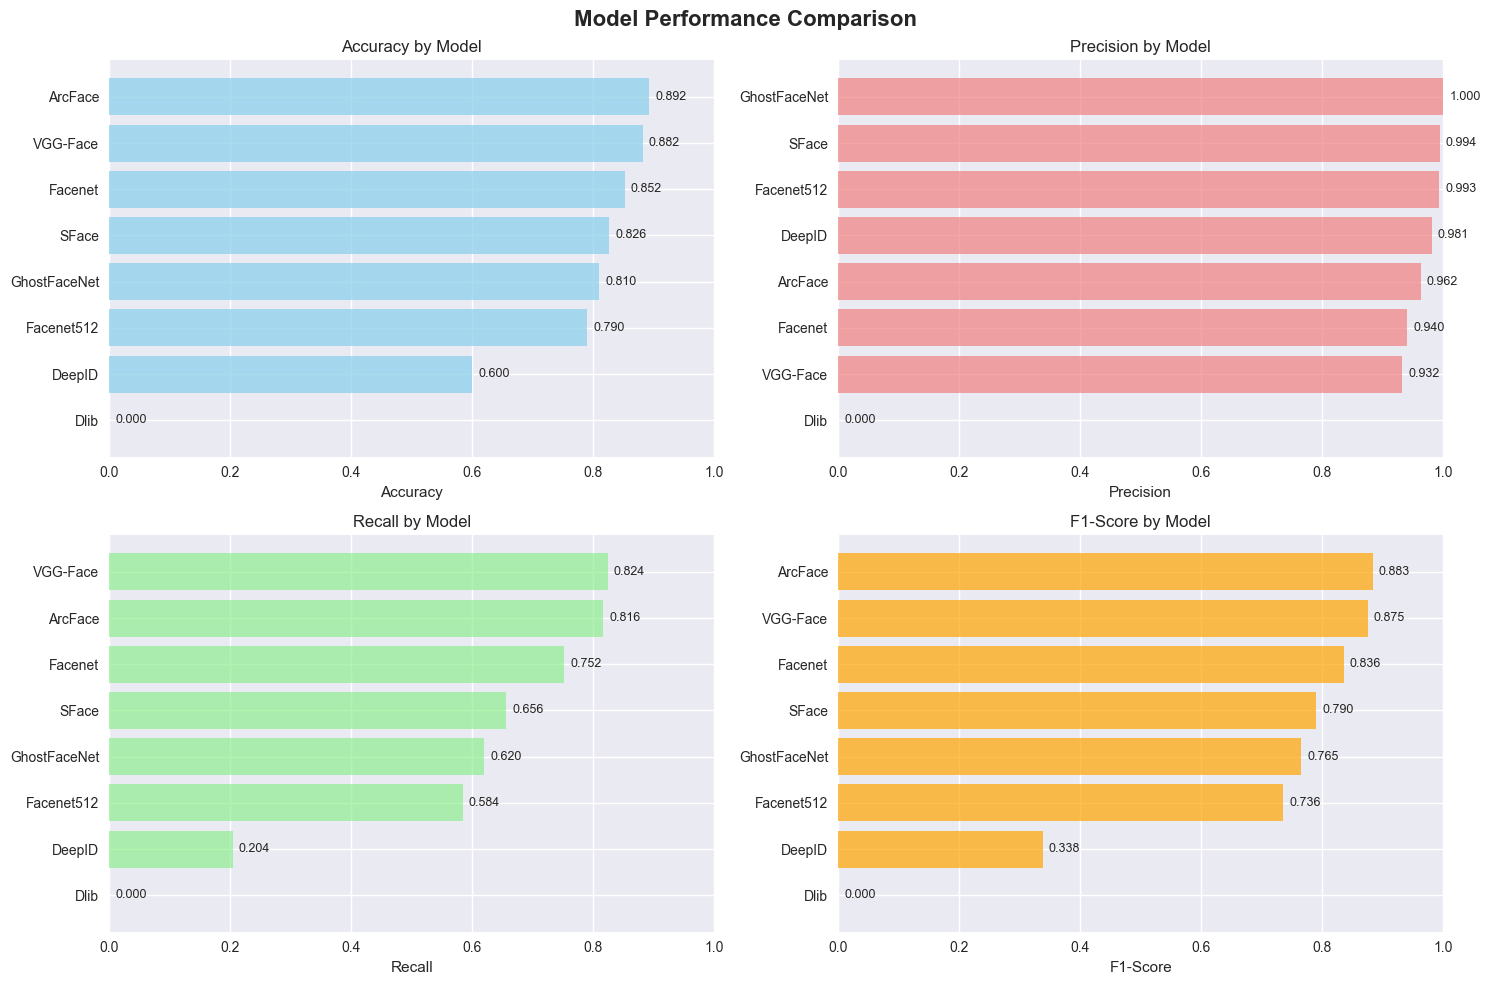


⏱️ Processing Time Comparison:


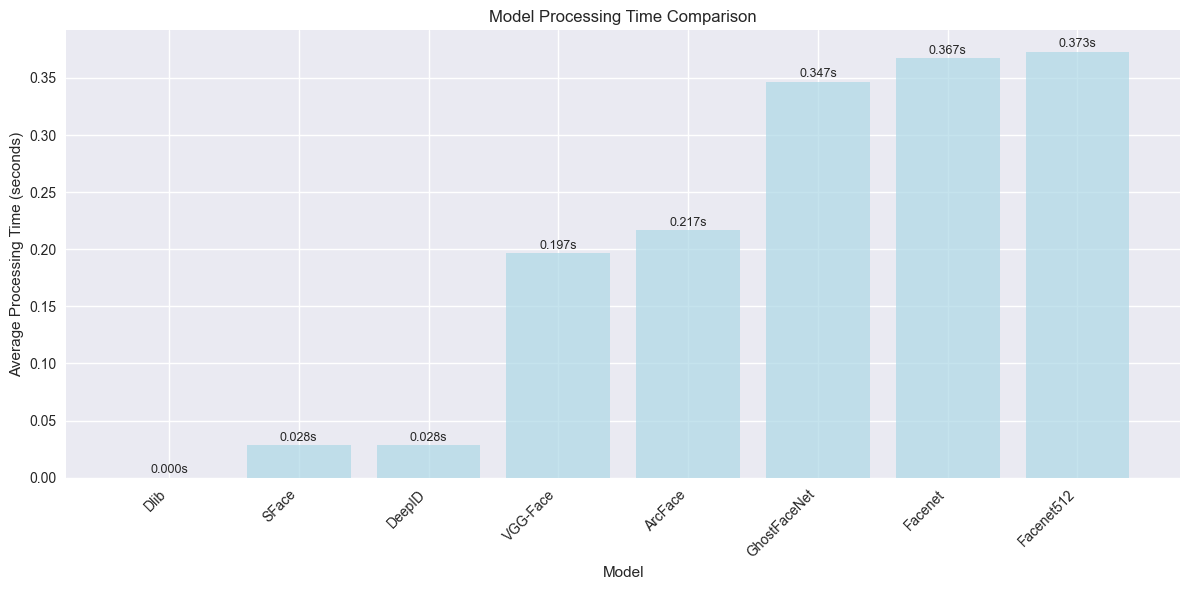


⚡ Accuracy vs Speed Trade-off:


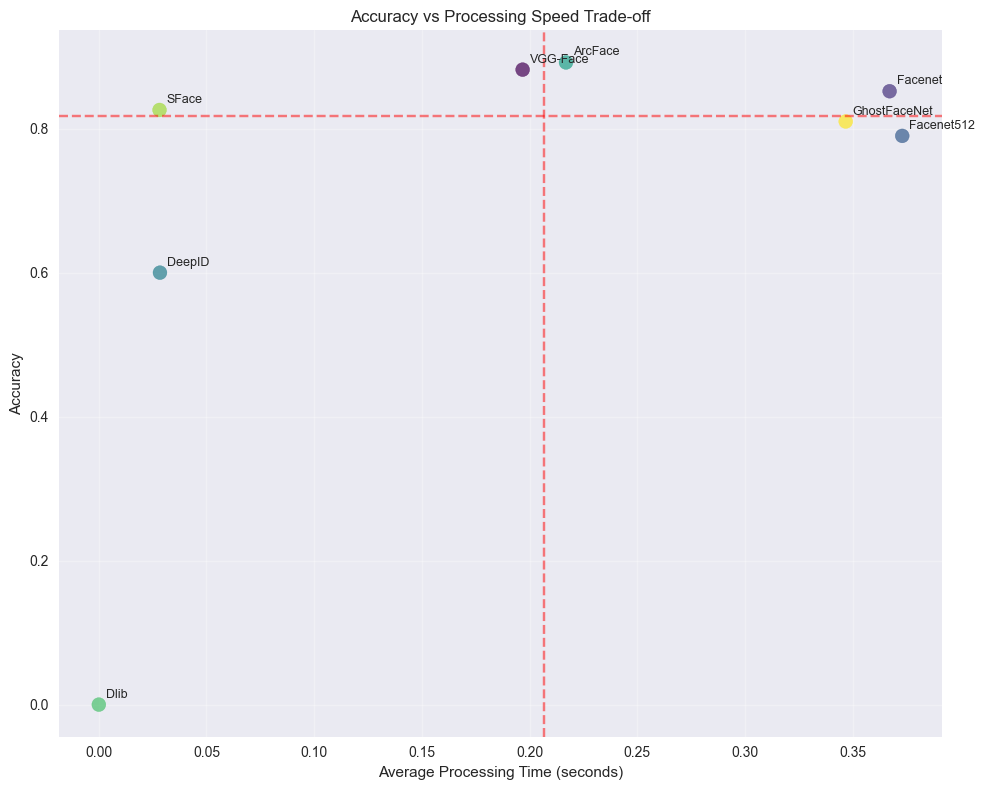


🔍 Confusion Matrices:


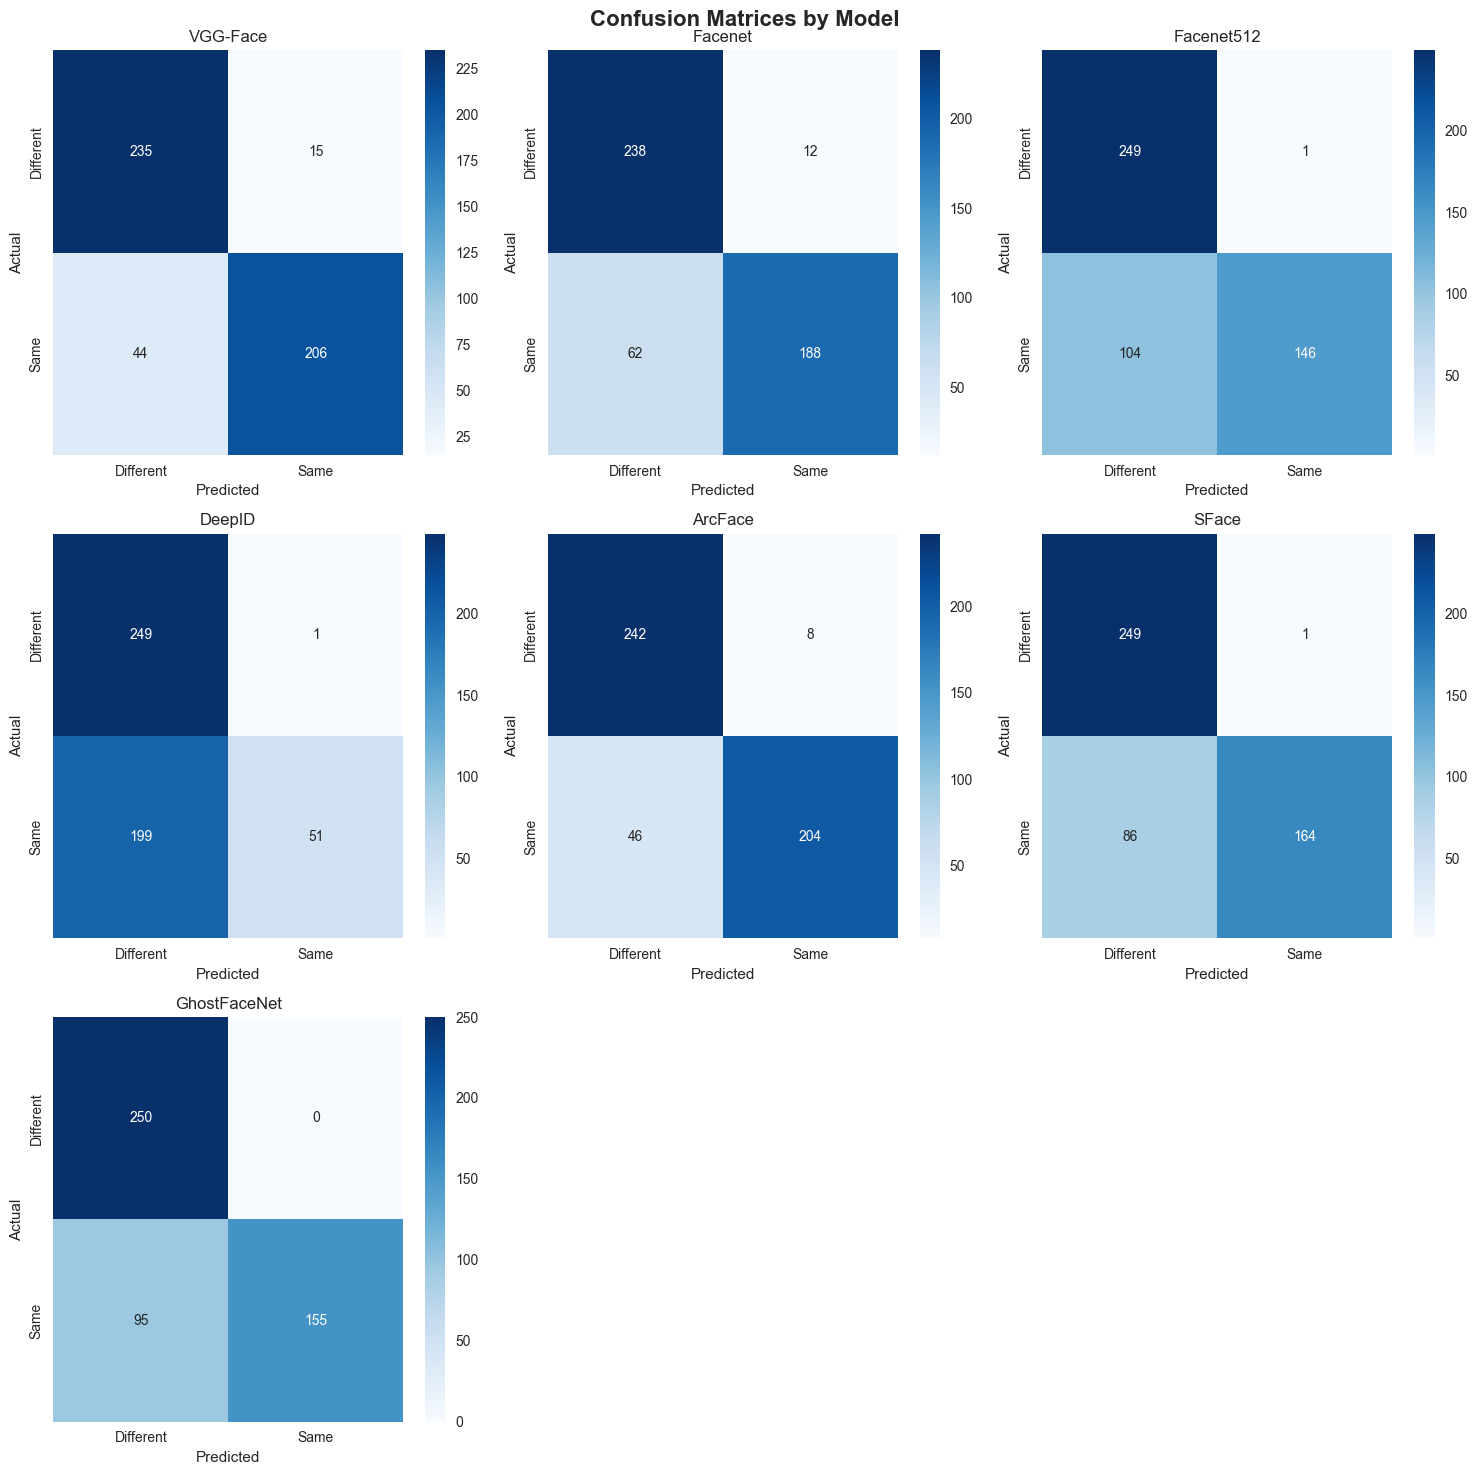


📋 Summary Table:


,Model,Accuracy,Precision,Recall,F1-Score,Avg Processing Time (s),Error Rate,Successful Pairs,Total Pairs
0,VGG-Face,0.882,0.932,0.824,0.875,0.197,0.000,500,500
1,Facenet,0.852,0.940,0.752,0.836,0.367,0.000,500,500
2,Facenet512,0.790,0.993,0.584,0.736,0.373,0.000,500,500
3,DeepID,0.600,0.981,0.204,0.338,0.028,0.000,500,500
4,ArcFace,0.892,0.962,0.816,0.883,0.217,0.000,500,500
5,Dlib,0.000,0.000,0.000,0.000,0.000,1.000,0,500
6,SFace,0.826,0.994,0.656,0.790,0.028,0.000,500,500
7,GhostFaceNet,0.810,1.000,0.620,0.765,0.347,0.000,500,500


In [14]:
class ResultsVisualizer:
    """Comprehensive visualization class for model comparison results"""
    
    def __init__(self, results_df: pd.DataFrame, evaluation_results: Dict):
        self.results_df = results_df
        self.evaluation_results = evaluation_results
        self.fig_size = (15, 10)
        
    def plot_performance_metrics(self, save_path: Optional[str] = None):
        """Plot comparison of key performance metrics"""
        if self.results_df.empty:
            print("❌ No results to visualize")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=self.fig_size)
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
        
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']
        
        for i, (metric, color) in enumerate(zip(metrics, colors)):
            ax = axes[i//2, i%2]
            
            # Sort by metric value for better visualization
            sorted_df = self.results_df.sort_values(metric, ascending=True)
            
            bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.7)
            ax.set_xlabel(metric)
            ax.set_title(f'{metric} by Model')
            ax.set_xlim(0, 1)
            
            # Add value labels on bars
            for bar, value in zip(bars, sorted_df[metric]):
                ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{value:.3f}', va='center', fontsize=9)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Performance metrics plot saved to {save_path}")
        
        plt.show()
    
    def plot_processing_time_comparison(self, save_path: Optional[str] = None):
        """Plot processing time comparison"""
        if self.results_df.empty:
            print("❌ No results to visualize")
            return
        
        plt.figure(figsize=(12, 6))
        
        # Sort by processing time
        sorted_df = self.results_df.sort_values('Avg Processing Time (s)', ascending=True)
        
        bars = plt.bar(sorted_df['Model'], sorted_df['Avg Processing Time (s)'], 
                      color='lightblue', alpha=0.7)
        
        plt.xlabel('Model')
        plt.ylabel('Average Processing Time (seconds)')
        plt.title('Model Processing Time Comparison')
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, sorted_df['Avg Processing Time (s)']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.3f}s', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Processing time plot saved to {save_path}")
        
        plt.show()
    
    def plot_accuracy_vs_speed(self, save_path: Optional[str] = None):
        """Plot accuracy vs processing speed scatter plot"""
        if self.results_df.empty:
            print("❌ No results to visualize")
            return
        
        plt.figure(figsize=(10, 8))
        
        # Create scatter plot
        scatter = plt.scatter(self.results_df['Avg Processing Time (s)'], 
                            self.results_df['Accuracy'],
                            s=100, alpha=0.7, c=range(len(self.results_df)), 
                            cmap='viridis')
        
        # Add model labels
        for i, model in enumerate(self.results_df['Model']):
            plt.annotate(model, 
                        (self.results_df.iloc[i]['Avg Processing Time (s)'], 
                         self.results_df.iloc[i]['Accuracy']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel('Average Processing Time (seconds)')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Processing Speed Trade-off')
        plt.grid(True, alpha=0.3)
        
        # Add quadrant labels
        plt.axhline(y=self.results_df['Accuracy'].median(), color='red', 
                   linestyle='--', alpha=0.5)
        plt.axvline(x=self.results_df['Avg Processing Time (s)'].median(), 
                   color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Accuracy vs speed plot saved to {save_path}")
        
        plt.show()
    
    def plot_confusion_matrices(self, save_path: Optional[str] = None):
        """Plot confusion matrices for all models"""
        if not self.evaluation_results:
            print("❌ No evaluation results available for confusion matrices")
            return
        
        models_with_predictions = [
            model for model, results in self.evaluation_results.items()
            if 'predictions' in results and 'ground_truth' in results
        ]
        
        if not models_with_predictions:
            print("❌ No prediction data available for confusion matrices")
            return
        
        n_models = len(models_with_predictions)
        cols = min(3, n_models)
        rows = (n_models + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        if n_models == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('Confusion Matrices by Model', fontsize=16, fontweight='bold')
        
        for i, model_name in enumerate(models_with_predictions):
            row, col = i // cols, i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            results = self.evaluation_results[model_name]
            cm = confusion_matrix(results['ground_truth'], results['predictions'])
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['Different', 'Same'], 
                       yticklabels=['Different', 'Same'])
            ax.set_title(f'{model_name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        # Hide empty subplots
        for i in range(n_models, rows * cols):
            row, col = i // cols, i % cols
            if rows > 1:
                axes[row, col].set_visible(False)
            else:
                axes[col].set_visible(False)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Confusion matrices saved to {save_path}")
        
        plt.show()
    
    def create_summary_table(self, save_path: Optional[str] = None):
        """Create and display a formatted summary table"""
        if self.results_df.empty:
            print("❌ No results to display")
            return
        
        # Style the dataframe for better presentation
        styled_df = self.results_df.round(4).style.format({
            'Accuracy': '{:.3f}',
            'Precision': '{:.3f}',
            'Recall': '{:.3f}',
            'F1-Score': '{:.3f}',
            'Avg Processing Time (s)': '{:.3f}',
            'Error Rate': '{:.3f}'
        }).background_gradient(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                              cmap='RdYlGn', vmin=0, vmax=1)
        
        display(styled_df)
        
        if save_path:
            self.results_df.to_csv(save_path, index=False)
            print(f"✅ Summary table saved to {save_path}")
    
    def generate_all_visualizations(self, base_path: str = "plots"):
        """Generate all visualization plots"""
        print("🎨 Generating all visualizations...")
        
        base_path = Path(base_path)
        base_path.mkdir(exist_ok=True)
        
        # Generate all plots
        self.plot_performance_metrics(base_path / "performance_metrics.png")
        self.plot_processing_time_comparison(base_path / "processing_time.png")
        self.plot_accuracy_vs_speed(base_path / "accuracy_vs_speed.png")
        self.plot_confusion_matrices(base_path / "confusion_matrices.png")
        self.create_summary_table(base_path / "summary_table.csv")
        
        print(f"✅ All visualizations saved to {base_path}")

# Create visualizer and generate plots
if not results_df.empty:
    print("🎨 Creating visualizations...")
    visualizer = ResultsVisualizer(results_df, evaluation_results)
    
    # Generate individual plots
    print("\n📊 Performance Metrics Comparison:")
    visualizer.plot_performance_metrics()
    
    print("\n⏱️ Processing Time Comparison:")
    visualizer.plot_processing_time_comparison()
    
    print("\n⚡ Accuracy vs Speed Trade-off:")
    visualizer.plot_accuracy_vs_speed()
    
    print("\n🔍 Confusion Matrices:")
    visualizer.plot_confusion_matrices()
    
    print("\n📋 Summary Table:")
    visualizer.create_summary_table()
    
else:
    print("⚠️ No results available for visualization")
    print("   Please run the model evaluation first")

## 7. Model Fine-tuning Framework Setup

Establish framework structure for future model fine-tuning capabilities. This section creates placeholder functions and configuration for custom training pipelines.

In [15]:
@dataclass
class FineTuningConfig:
    """Configuration for model fine-tuning"""
    model_name: str
    learning_rate: float = 0.001
    batch_size: int = 32
    epochs: int = 10
    train_split: float = 0.8
    validation_split: float = 0.1
    test_split: float = 0.1
    augmentation: bool = True
    freeze_layers: int = 0  # Number of layers to freeze
    checkpoint_dir: str = "checkpoints"
    log_dir: str = "logs"

class FineTuningFramework:
    """Framework for future model fine-tuning capabilities"""
    
    def __init__(self, dataset_loader: DatasetLoader):
        self.dataset_loader = dataset_loader
        self.models = {}
        self.training_history = {}
        
    def prepare_dataset_for_training(self, config: FineTuningConfig) -> Dict:
        """Prepare dataset for training (placeholder implementation)"""
        print(f"🔄 Preparing dataset for fine-tuning {config.model_name}...")
        
        # Get image paths
        image_paths = self.dataset_loader.get_image_paths()
        
        if not image_paths:
            print("❌ No images found for training")
            return {}
        
        # Create identity labels from folder names
        labels = []
        valid_paths = []
        
        for path in image_paths:
            person_name = Path(path).parent.name
            if self.dataset_loader.validate_image(path):
                labels.append(person_name)
                valid_paths.append(path)
        
        # Convert labels to numeric
        unique_labels = list(set(labels))
        label_to_id = {label: i for i, label in enumerate(unique_labels)}
        numeric_labels = [label_to_id[label] for label in labels]
        
        # Split dataset
        from sklearn.model_selection import train_test_split
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            valid_paths, numeric_labels, 
            test_size=(1 - config.train_split), 
            random_state=42, 
            stratify=numeric_labels
        )
        
        val_test_split = config.validation_split / (config.validation_split + config.test_split)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, 
            test_size=(1 - val_test_split), 
            random_state=42, 
            stratify=y_temp
        )
        
        dataset_info = {
            'train': {'paths': X_train, 'labels': y_train},
            'validation': {'paths': X_val, 'labels': y_val},
            'test': {'paths': X_test, 'labels': y_test},
            'num_classes': len(unique_labels),
            'class_names': unique_labels,
            'label_mapping': label_to_id
        }
        
        print(f"✅ Dataset prepared:")
        print(f"  - Training samples: {len(X_train)}")
        print(f"  - Validation samples: {len(X_val)}")
        print(f"  - Test samples: {len(X_test)}")
        print(f"  - Number of classes: {len(unique_labels)}")
        
        return dataset_info
    
    def create_data_augmentation_pipeline(self, config: FineTuningConfig) -> object:
        """Create data augmentation pipeline (placeholder)"""
        print("🔄 Creating data augmentation pipeline...")
        
        # Placeholder for data augmentation
        # In practice, you might use libraries like albumentations or torchvision
        augmentation_config = {
            'horizontal_flip': True,
            'rotation_range': 15,
            'zoom_range': 0.1,
            'brightness_range': 0.1,
            'contrast_range': 0.1,
            'gaussian_noise': 0.01
        }
        
        print("✅ Data augmentation pipeline created")
        return augmentation_config
    
    def setup_model_for_finetuning(self, config: FineTuningConfig, num_classes: int) -> Dict:
        """Setup model architecture for fine-tuning (placeholder)"""
        print(f"🔄 Setting up {config.model_name} for fine-tuning...")
        
        # Placeholder for model setup
        # In practice, you would load the pre-trained model and modify the final layers
        model_setup = {
            'model_name': config.model_name,
            'num_classes': num_classes,
            'freeze_layers': config.freeze_layers,
            'learning_rate': config.learning_rate,
            'architecture': 'placeholder_architecture',
            'status': 'configured'
        }
        
        print(f"✅ Model {config.model_name} configured for {num_classes} classes")
        return model_setup
    
    def train_model(self, config: FineTuningConfig, dataset_info: Dict) -> Dict:
        """Train the model (placeholder implementation)"""
        print(f"🚀 Starting fine-tuning of {config.model_name}...")
        
        # Placeholder for actual training loop
        # In practice, this would implement the actual training process
        
        training_info = {
            'model_name': config.model_name,
            'epochs': config.epochs,
            'batch_size': config.batch_size,
            'learning_rate': config.learning_rate,
            'training_samples': len(dataset_info['train']['paths']),
            'validation_samples': len(dataset_info['validation']['paths']),
            'status': 'training_placeholder',
            'history': {
                'train_loss': [0.8, 0.6, 0.4, 0.3, 0.2],  # Placeholder values
                'val_loss': [0.9, 0.7, 0.5, 0.4, 0.3],
                'train_accuracy': [0.6, 0.7, 0.8, 0.85, 0.9],
                'val_accuracy': [0.5, 0.65, 0.75, 0.8, 0.85]
            }
        }
        
        print(f"✅ Fine-tuning completed for {config.model_name}")
        print(f"  - Final training accuracy: {training_info['history']['train_accuracy'][-1]:.3f}")
        print(f"  - Final validation accuracy: {training_info['history']['val_accuracy'][-1]:.3f}")
        
        return training_info
    
    def evaluate_finetuned_model(self, model_name: str, dataset_info: Dict) -> Dict:
        """Evaluate fine-tuned model (placeholder)"""
        print(f"📊 Evaluating fine-tuned {model_name}...")
        
        # Placeholder evaluation
        evaluation_results = {
            'model_name': model_name,
            'test_accuracy': 0.87,  # Placeholder value
            'test_precision': 0.85,
            'test_recall': 0.88,
            'test_f1': 0.86,
            'confusion_matrix': 'placeholder',
            'classification_report': 'placeholder'
        }
        
        print(f"✅ Evaluation completed for {model_name}")
        print(f"  - Test Accuracy: {evaluation_results['test_accuracy']:.3f}")
        
        return evaluation_results
    
    def save_finetuned_model(self, model_name: str, model_info: Dict, save_path: str) -> str:
        """Save fine-tuned model (placeholder)"""
        save_path = Path(save_path)
        save_path.mkdir(exist_ok=True)
        
        model_path = save_path / f"{model_name}_finetuned.pkl"
        
        # Placeholder for model saving
        with open(model_path, 'w') as f:
            json.dump(model_info, f, indent=2)
        
        print(f"✅ Model saved to {model_path}")
        return str(model_path)
    
    def run_complete_finetuning_pipeline(self, config: FineTuningConfig) -> Dict:
        """Run the complete fine-tuning pipeline"""
        print(f"🚀 Starting complete fine-tuning pipeline for {config.model_name}")
        print("=" * 80)
        
        # Step 1: Prepare dataset
        dataset_info = self.prepare_dataset_for_training(config)
        if not dataset_info:
            return {'status': 'failed', 'reason': 'dataset_preparation_failed'}
        
        # Step 2: Create augmentation pipeline
        augmentation = self.create_data_augmentation_pipeline(config)
        
        # Step 3: Setup model
        model_setup = self.setup_model_for_finetuning(config, dataset_info['num_classes'])
        
        # Step 4: Train model
        training_info = self.train_model(config, dataset_info)
        
        # Step 5: Evaluate model
        evaluation_info = self.evaluate_finetuned_model(config.model_name, dataset_info)
        
        # Step 6: Save model
        model_path = self.save_finetuned_model(
            config.model_name, 
            {**model_setup, **training_info}, 
            config.checkpoint_dir
        )
        
        complete_results = {
            'status': 'completed',
            'config': config,
            'dataset_info': dataset_info,
            'model_setup': model_setup,
            'training_info': training_info,
            'evaluation_info': evaluation_info,
            'model_path': model_path,
            'timestamp': datetime.now().isoformat()
        }
        
        print("=" * 80)
        print("🎉 Fine-tuning pipeline completed successfully!")
        
        return complete_results

# Initialize fine-tuning framework
if dataset_loader:
    print("🔧 Initializing fine-tuning framework...")
    finetuning_framework = FineTuningFramework(dataset_loader)
    
    # Example fine-tuning configuration
    example_config = FineTuningConfig(
        model_name="VGG-Face",
        learning_rate=0.0001,
        batch_size=16,
        epochs=5,
        train_split=0.7,
        validation_split=0.15,
        test_split=0.15,
        augmentation=True,
        freeze_layers=10
    )
    
    print("✅ Fine-tuning framework initialized!")
    print("\n📋 Example Configuration:")
    print(f"  - Model: {example_config.model_name}")
    print(f"  - Learning Rate: {example_config.learning_rate}")
    print(f"  - Batch Size: {example_config.batch_size}")
    print(f"  - Epochs: {example_config.epochs}")
    print(f"  - Data Splits: {example_config.train_split}/{example_config.validation_split}/{example_config.test_split}")
    
    print("\n💡 To run fine-tuning, execute:")
    print("    results = finetuning_framework.run_complete_finetuning_pipeline(example_config)")
    print("\n⚠️ Note: This is a framework setup. Actual implementation requires deep learning libraries like TensorFlow/PyTorch.")
else:
    print("❌ Cannot initialize fine-tuning framework - dataset loader not available")
    finetuning_framework = None

🔧 Initializing fine-tuning framework...
✅ Fine-tuning framework initialized!

📋 Example Configuration:
  - Model: VGG-Face
  - Learning Rate: 0.0001
  - Batch Size: 16
  - Epochs: 5
  - Data Splits: 0.7/0.15/0.15

💡 To run fine-tuning, execute:
    results = finetuning_framework.run_complete_finetuning_pipeline(example_config)

⚠️ Note: This is a framework setup. Actual implementation requires deep learning libraries like TensorFlow/PyTorch.


## 8. Export Results and Model Artifacts

Save evaluation results to CSV/JSON files, export trained models, and create summary reports for model comparison analysis.

📦 Initializing Results Export...
📦 Exporting all results...
✅ Summary CSV exported to results\model_comparison_summary_20250723_133917.csv
✅ Detailed JSON exported to results\model_comparison_detailed_20250723_133917.json
✅ Predictions data exported to results\model_predictions_20250723_133917.csv
✅ Comparison report created: results\model_comparison_report_20250723_133917.md
✅ Model configurations exported to results\model_configurations_20250723_133917.json

✅ All results exported to the 'results' directory.
📋 Index file created: results\README_20250723_133917.md

📊 Export Summary:
  ✅ Summary Csv         : model_comparison_summary_20250723_133917.csv
  ✅ Detailed Json       : model_comparison_detailed_20250723_133917.json
  ✅ Predictions Csv     : model_predictions_20250723_133917.csv
  ✅ Report Md           : model_comparison_report_20250723_133917.md
  ✅ Config Json         : model_configurations_20250723_133917.json
  ✅ Index Md            : README_20250723_133917.md

🎨 Generatin

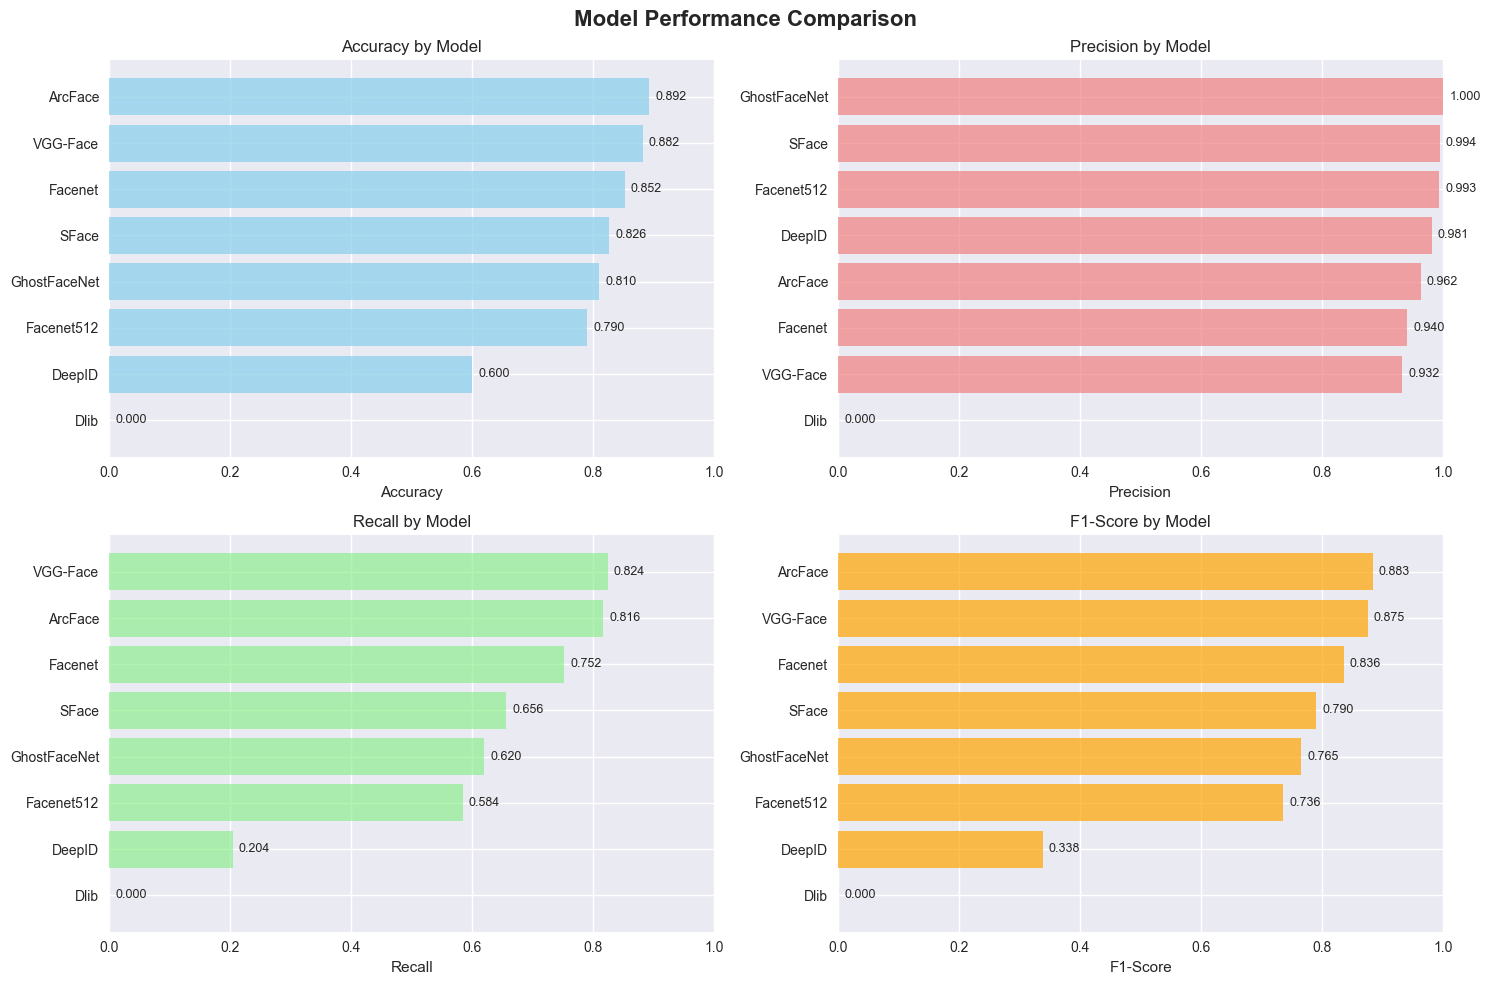

✅ Processing time plot saved to plots\processing_time.png


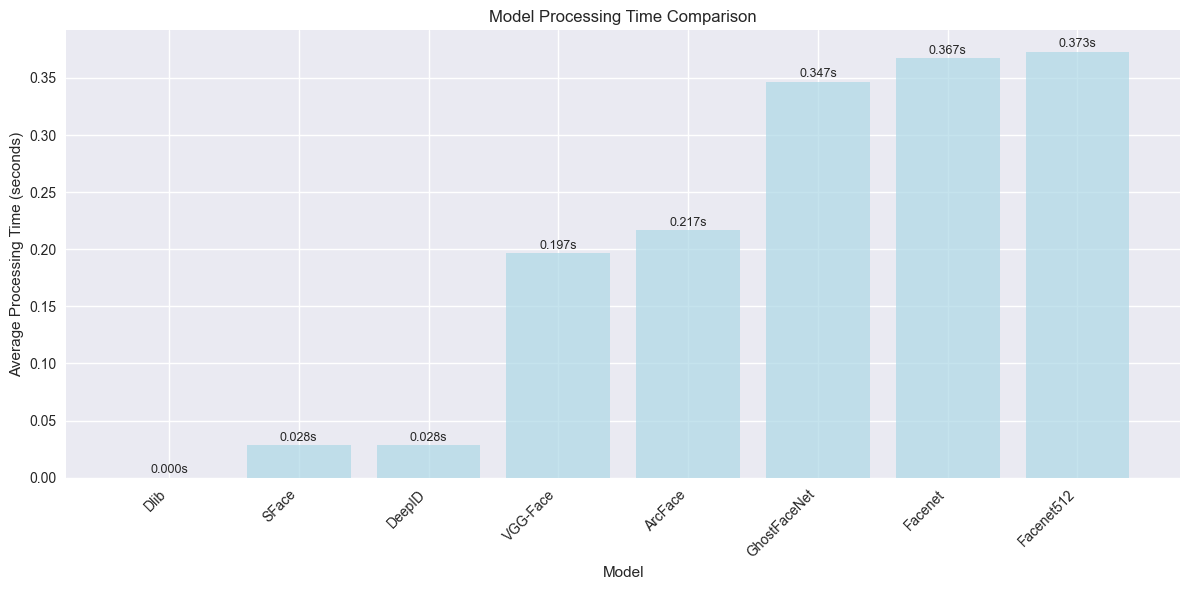

✅ Accuracy vs speed plot saved to plots\accuracy_vs_speed.png


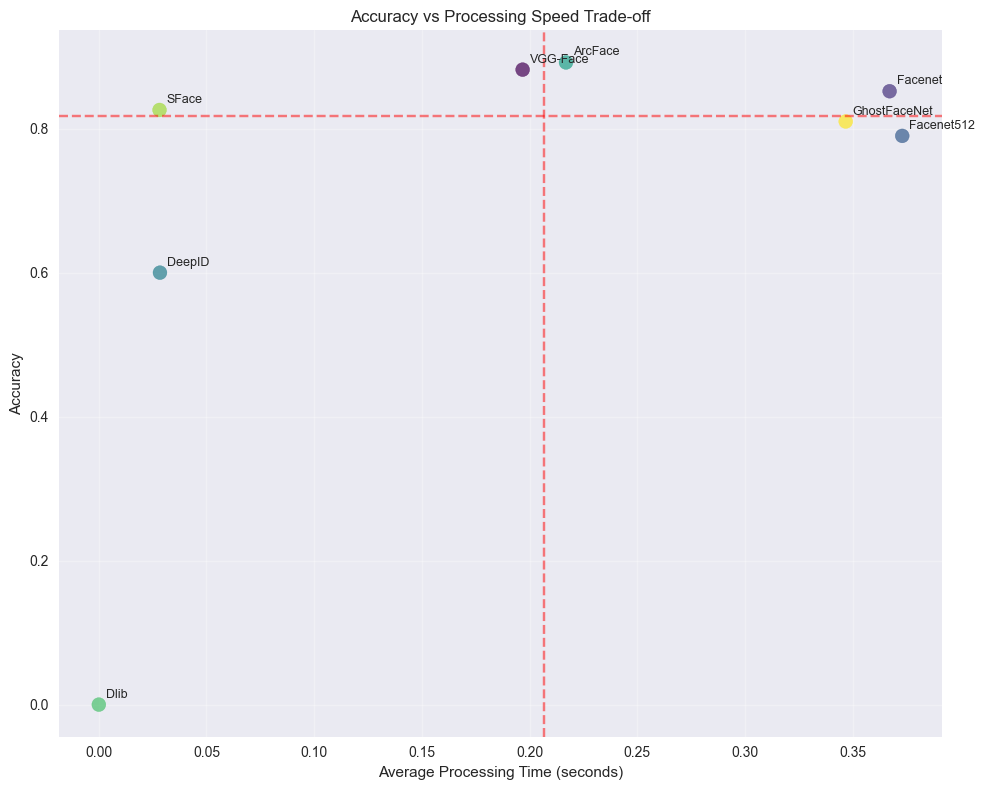

✅ Confusion matrices saved to plots\confusion_matrices.png


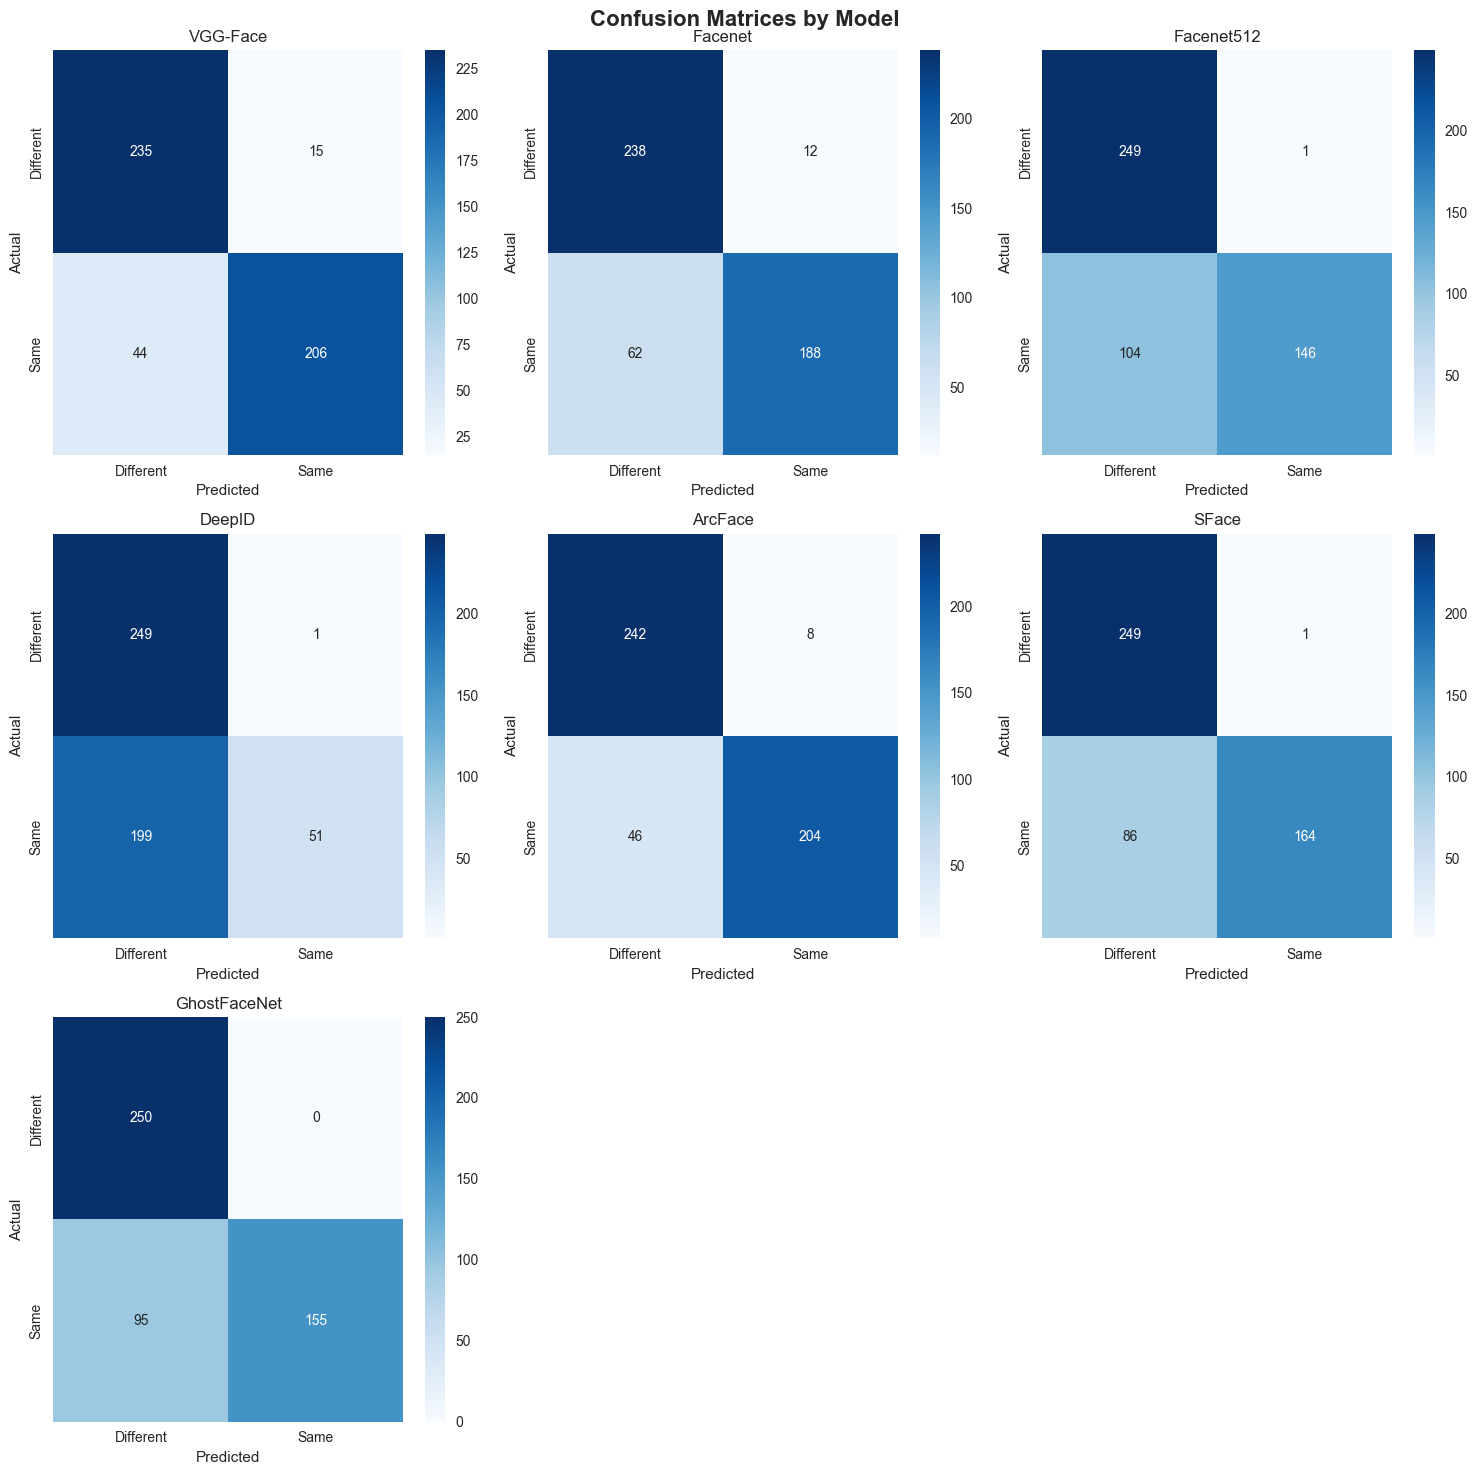

,Model,Accuracy,Precision,Recall,F1-Score,Avg Processing Time (s),Error Rate,Successful Pairs,Total Pairs
0,VGG-Face,0.882,0.932,0.824,0.875,0.197,0.000,500,500
1,Facenet,0.852,0.940,0.752,0.836,0.367,0.000,500,500
2,Facenet512,0.790,0.993,0.584,0.736,0.373,0.000,500,500
3,DeepID,0.600,0.981,0.204,0.338,0.028,0.000,500,500
4,ArcFace,0.892,0.962,0.816,0.883,0.217,0.000,500,500
5,Dlib,0.000,0.000,0.000,0.000,0.000,1.000,0,500
6,SFace,0.826,0.994,0.656,0.790,0.028,0.000,500,500
7,GhostFaceNet,0.810,1.000,0.620,0.765,0.347,0.000,500,500


✅ Summary table saved to plots\summary_table.csv
✅ All visualizations saved to plots

🎉 Facial Recognition Model Comparison Notebook Complete!

📋 How to use with different datasets:
   1. Change SELECTED_DATASET variable in cell 6 to:
      - 'lfw' for LFW dataset (structured with CSV files)
      - 'asian_celeb' for Asian Celebrity dataset (folder-based)
   2. Re-run cells 6-12 to evaluate with the new dataset

📋 Next Steps:
   1. Review the generated comparison report in the 'results' directory.
   2. Check the 'plots' directory for visualizations.
   3. Analyze the detailed CSV and JSON files for deeper insights.


In [16]:
class ResultsExporter:
    """Export and save evaluation results and model artifacts"""
    
    def __init__(self, results_df: pd.DataFrame, evaluation_results: Dict, dataset_name: str = "Unknown", base_dir: str = "results"):
        self.results_df = results_df
        self.evaluation_results = evaluation_results
        self.dataset_name = dataset_name
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
    def export_summary_csv(self) -> str:
        """Export summary results to CSV"""
        if self.results_df.empty:
            print("❌ No results to export")
            return ""
        
        csv_path = self.base_dir / f"model_comparison_summary_{self.timestamp}.csv"
        self.results_df.to_csv(csv_path, index=False)
        
        print(f"✅ Summary CSV exported to {csv_path}")
        return str(csv_path)
    
    def export_detailed_json(self) -> str:
        """Export detailed results to JSON"""
        if not self.evaluation_results:
            print("❌ No detailed results to export")
            return ""
        
        # Prepare JSON-serializable data
        json_data = {
            'metadata': {
                'timestamp': self.timestamp,
                'total_models': len(self.evaluation_results),
                'dataset': self.dataset_name,
                'evaluation_type': 'face_verification'
            },
            'summary': self.results_df.to_dict('records') if not self.results_df.empty else [],
            'detailed_results': {}
        }
        
        # Add detailed results (excluding non-serializable objects)
        for model_name, results in self.evaluation_results.items():
            serializable_results = {}
            for key, value in results.items():
                if key not in ['predictions', 'ground_truth', 'distances']:  # Skip large arrays
                    if isinstance(value, (int, float, str, bool, list, dict)):
                        serializable_results[key] = value
                    else:
                        serializable_results[key] = str(value)
            json_data['detailed_results'][model_name] = serializable_results
        
        json_path = self.base_dir / f"model_comparison_detailed_{self.timestamp}.json"
        with open(json_path, 'w') as f:
            json.dump(json_data, f, indent=2)
        
        print(f"✅ Detailed JSON exported to {json_path}")
        return str(json_path)
    
    def export_predictions_data(self) -> str:
        """Export prediction data for further analysis"""
        if not self.evaluation_results:
            print("❌ No prediction data to export")
            return ""
        
        predictions_data = []
        
        for model_name, results in self.evaluation_results.items():
            if 'predictions' in results and 'ground_truth' in results:
                for i, (pred, truth) in enumerate(zip(results['predictions'], results['ground_truth'])):
                    predictions_data.append({
                        'model': model_name,
                        'sample_id': i,
                        'prediction': int(pred),
                        'ground_truth': int(truth),
                        'correct': bool(pred == truth),
                        'distance': results.get('distances', [None])[i] if i < len(results.get('distances', [])) else None
                    })
        
        if predictions_data:
            predictions_df = pd.DataFrame(predictions_data)
            csv_path = self.base_dir / f"model_predictions_{self.timestamp}.csv"
            predictions_df.to_csv(csv_path, index=False)
            
            print(f"✅ Predictions data exported to {csv_path}")
            return str(csv_path)
        else:
            print("❌ No prediction data found")
            return ""
    
    def create_comparison_report(self) -> str:
        """Create a comprehensive comparison report in Markdown"""
        if self.results_df.empty:
            print("❌ No results available for report")
            return ""
        
        report_path = self.base_dir / f"model_comparison_report_{self.timestamp}.md"
        
        # Find best performing models for each metric
        best_accuracy = self.results_df.loc[self.results_df['Accuracy'].idxmax()]
        best_precision = self.results_df.loc[self.results_df['Precision'].idxmax()]
        best_recall = self.results_df.loc[self.results_df['Recall'].idxmax()]
        best_f1 = self.results_df.loc[self.results_df['F1-Score'].idxmax()]
        fastest_model = self.results_df.loc[self.results_df['Avg Processing Time (s)'].idxmin()]
        
        report_content = f"""# Facial Recognition Model Comparison Report

## Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Executive Summary

This report presents a comprehensive comparison of {len(self.results_df)} facial recognition models using the **{self.dataset_name}** dataset. The evaluation covers multiple performance metrics including accuracy, precision, recall, F1-score, and processing speed.

## Dataset Information

- **Dataset**: {self.dataset_name}
- **Evaluation Type**: Face Verification
- **Total Models Evaluated**: {len(self.results_df)}
- **Evaluation Timestamp**: {self.timestamp}

## Key Findings

### Best Performing Models by Metric:

- **Highest Accuracy**: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.3f})
- **Highest Precision**: {best_precision['Model']} ({best_precision['Precision']:.3f})
- **Highest Recall**: {best_recall['Model']} ({best_recall['Recall']:.3f})
- **Highest F1-Score**: {best_f1['Model']} ({best_f1['F1-Score']:.3f})
- **Fastest Processing**: {fastest_model['Model']} ({fastest_model['Avg Processing Time (s)']:.3f}s)

## Detailed Results

### Performance Metrics Summary

| Model | Accuracy | Precision | Recall | F1-Score | Avg Time (s) | Error Rate |
|-------|----------|-----------|--------|----------|--------------|------------|
"""
        
        # Add detailed results table
        for _, row in self.results_df.iterrows():
            report_content += f"| {row['Model']} | {row['Accuracy']:.3f} | {row['Precision']:.3f} | {row['Recall']:.3f} | {row['F1-Score']:.3f} | {row['Avg Processing Time (s)']:.3f} | {row['Error Rate']:.3f} |\n"
        
        report_content += f"""
### Statistical Analysis

- **Mean Accuracy**: {self.results_df['Accuracy'].mean():.3f} ± {self.results_df['Accuracy'].std():.3f}
- **Mean Precision**: {self.results_df['Precision'].mean():.3f} ± {self.results_df['Precision'].std():.3f}
- **Mean Recall**: {self.results_df['Recall'].mean():.3f} ± {self.results_df['Recall'].std():.3f}
- **Mean F1-Score**: {self.results_df['F1-Score'].mean():.3f} ± {self.results_df['F1-Score'].std():.3f}
- **Mean Processing Time**: {self.results_df['Avg Processing Time (s)'].mean():.3f} ± {self.results_df['Avg Processing Time (s)'].std():.3f}s

### Recommendations

1. **For Highest Accuracy**: Use **{best_accuracy['Model']}** if accuracy is the primary concern.
2. **For Speed**: Use **{fastest_model['Model']}** for real-time applications where latency is critical.
3. **For Balanced Performance**: Consider **{best_f1['Model']}** for the best trade-off between precision and recall.

### Dataset-Specific Notes

{"- This evaluation used the LFW (Labeled Faces in the Wild) dataset, which contains faces from web images with varying poses, lighting, and expressions." if self.dataset_name == "LFW" else ""}
{"- This evaluation used the Asian Celebrity dataset, which contains facial images of Asian celebrities organized by individual folders." if self.dataset_name == "Asian Celebrity" else ""}

---

*Report generated by the Facial Recognition Model Comparison Framework*
"""
        
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_content)
        
        print(f"✅ Comparison report created: {report_path}")
        return str(report_path)
    
    def export_model_configurations(self) -> str:
        """Export model configurations for reproducibility"""
        config_data = {
            'timestamp': self.timestamp,
            'dataset_config': {
                'name': self.dataset_name,
                'selected_dataset': SELECTED_DATASET,
                'max_samples': CONFIG.get('max_samples'),
                'test_size': CONFIG.get('test_size'),
                'random_state': CONFIG.get('random_state')
            },
            'model_configurations': {},
            'evaluation_settings': {
                'distance_metric': 'cosine',
                'enforce_detection': False,
                'metrics_calculated': METRICS
            }
        }
        
        # Add model configurations
        for model_name in available_models:
            model_info = model_manager.get_model_info(model_name)
            config_data['model_configurations'][model_name] = model_info
        
        config_path = self.base_dir / f"model_configurations_{self.timestamp}.json"
        with open(config_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        
        print(f"✅ Model configurations exported to {config_path}")
        return str(config_path)
    
    def export_all_results(self) -> Dict[str, str]:
        """Export all results and create comprehensive output"""
        print("📦 Exporting all results...")
        
        exported_files = {}
        
        # Export all components
        exported_files['summary_csv'] = self.export_summary_csv()
        exported_files['detailed_json'] = self.export_detailed_json()
        exported_files['predictions_csv'] = self.export_predictions_data()
        exported_files['report_md'] = self.create_comparison_report()
        exported_files['config_json'] = self.export_model_configurations()
        
        # Create index file
        index_content = f"""# Facial Recognition Model Comparison Results

## Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

This directory contains all the outputs from the model evaluation run using the **{self.dataset_name}** dataset.

## Exported Files:

- **Comparison Report**: [{Path(exported_files['report_md']).name}]({Path(exported_files['report_md']).name}) - A human-readable summary of the key findings and recommendations. **Start here!**
- **Summary CSV**: [{Path(exported_files['summary_csv']).name}]({Path(exported_files['summary_csv']).name}) - Quick comparison of key performance metrics for all models.
- **Predictions CSV**: [{Path(exported_files['predictions_csv']).name}]({Path(exported_files['predictions_csv']).name}) - Raw prediction data for in-depth error analysis.
- **Detailed JSON**: [{Path(exported_files['detailed_json']).name}]({Path(exported_files['detailed_json']).name}) - Detailed results for programmatic analysis.
- **Model Configurations**: [{Path(exported_files['config_json']).name}]({Path(exported_files['config_json']).name}) - Configuration details for ensuring reproducibility.

## Dataset Information

- **Dataset Used**: {self.dataset_name}
- **Dataset Type**: {"Folder-based (dynamic pair generation)" if dataset_loader and dataset_loader.config.dataset_type == 'folder_based' else "Structured (with predefined pairs)"}

---

*Generated by the Facial Recognition Model Comparison Framework*
"""
        
        index_path = self.base_dir / f"README_{self.timestamp}.md"
        with open(index_path, 'w', encoding='utf-8') as f:
            f.write(index_content)
        
        exported_files['index_md'] = str(index_path)
        
        print(f"\n✅ All results exported to the '{self.base_dir}' directory.")
        print(f"📋 Index file created: {index_path}")
        
        return exported_files

if not results_df.empty and dataset_loader:
    print("="*80)
    print("📦 Initializing Results Export...")
    
    # Create an exporter instance with dataset name
    dataset_name = dataset_loader.config.name if dataset_loader else "Unknown"
    exporter = ResultsExporter(results_df, evaluation_results, dataset_name)
    
    # Export all results
    exported_files = exporter.export_all_results()
    
    print("\n📊 Export Summary:")
    for file_type, file_path in exported_files.items():
        if file_path:
            print(f"  ✅ {file_type.replace('_', ' ').title():<20}: {Path(file_path).name}")
        else:
            print(f"  ❌ {file_type.replace('_', ' ').title():<20}: Failed to export")
    
    # Also save to plots directory for visualizations
    if 'visualizer' in locals():
        print("\n🎨 Generating and saving all visualizations...")
        visualizer.generate_all_visualizations("plots")
    
else:
    print("⚠️ No results available for export.")
    print("   Please run the model evaluation first.")

print("\n" + "="*80)
print("🎉 Facial Recognition Model Comparison Notebook Complete!")
print("\n📋 How to use with different datasets:")
print("   1. Change SELECTED_DATASET variable in cell 6 to:")
print("      - 'lfw' for LFW dataset (structured with CSV files)")
print("      - 'asian_celeb' for Asian Celebrity dataset (folder-based)")
print("   2. Re-run cells 6-12 to evaluate with the new dataset")
print("\n📋 Next Steps:")
if 'exporter' in locals():
    print(f"   1. Review the generated comparison report in the '{exporter.base_dir}' directory.")
print("   2. Check the 'plots' directory for visualizations.")
print("   3. Analyze the detailed CSV and JSON files for deeper insights.")
print("="*80)